# Data Visualizations

In [9]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as pc
from wordcloud import WordCloud
import ast
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json



In [10]:
%load_ext watermark

In [11]:
%watermark -iv

json      : 2.0.9
plotly    : 5.11.0
pandas    : 1.4.2
matplotlib: 3.5.1



# Data Viz 1
Check and compare balance of each dataset (train and test set)

In [2]:
df_train = pd.read_csv(r"C:\Users\riccardoricci\Documents\data_MADS_CAPSTONE\train_features.csv")
df_test = pd.read_csv(r"C:\Users\riccardoricci\Documents\data_MADS_CAPSTONE\test_features.csv")

In [3]:
# Create a consistent color map
palette = pc.qualitative.Plotly  # You can pick others like 'Set3', 'Pastel', etc.

color_map = {cat: palette[i % len(palette)] for i, cat in enumerate(sorted(df_train.puor_ds_level1_new.unique()))}

In [4]:
df_train_sunburst = df_train[[
    "puor_ds_level1_new",
    "puor_ds_level2_new",
    "puor_ds_level3_new",
    "puor_ds_level4_new"
]].dropna()

df_test_sunburst = df_test[[
    "puor_ds_level1_new",
    "puor_ds_level2_new",
    "puor_ds_level3_new",
    "puor_ds_level4_new"
]].dropna()

# Create individual sunburst figures
fig_train = px.sunburst(
    df_train_sunburst,
    path=[
        "puor_ds_level1_new",
        "puor_ds_level2_new",
        "puor_ds_level3_new",
    "puor_ds_level4_new"
    ],
    title="Sunburst Chart of Spending Category Hierarchy (TRAIN)",
    color="puor_ds_level1_new",
    color_discrete_map=color_map
)

fig_test = px.sunburst(
    df_test_sunburst,
    path=[
        "puor_ds_level1_new",
        "puor_ds_level2_new",
        "puor_ds_level3_new",
    "puor_ds_level4_new"
    ],
    title="Sunburst Chart of Spending Category Hierarchy (TEST)",
    color="puor_ds_level1_new",
    color_discrete_map=color_map
)

# Create a side-by-side subplot
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type':'domain'}, {'type':'domain'}]],
    subplot_titles=("Train Data", "Test Data")
)

# Add sunbursts to subplot
fig.add_trace(fig_train.data[0], row=1, col=1)
fig.add_trace(fig_test.data[0], row=1, col=2)

fig.update_layout(
    width=1600, height=800,
    title_text="Spending Categories Hierarchy (Train vs Test) by Number of Purchase Orders",
    title_x=0.5
)

fig.show()


# Data Viz 2

World Cloud: Which words are most determinant to predict a category

In [5]:
# Masking sensitive words
path = r'C:\Users\riccardoricci\Documents\data_MADS_CAPSTONE\masking_sens_words.json'

with open(path, 'r', encoding='utf-8') as file:
    sensitive_replacements = json.load(file)

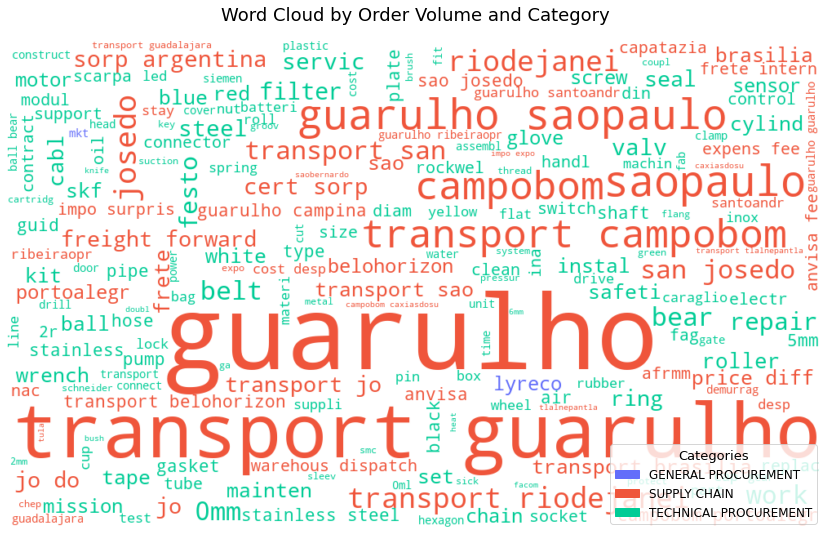

In [6]:
# Convert stringified lists to actual lists
df_train['puor_ds_po_description_translated_token_sklearn_stem'] = df_train['puor_ds_po_description_translated_token_sklearn_stem'].apply(ast.literal_eval)

# Explode tokens -> from an array to rows and count the occurrence
df_exploded = df_train.explode('puor_ds_po_description_translated_token_sklearn_stem')
df_exploded = df_exploded[df_exploded['puor_ds_po_description_translated_token_sklearn_stem'].notnull()]
df_exploded = df_exploded[df_exploded['puor_ds_po_description_translated_token_sklearn_stem'] != '']

# Group by token and category
grouped = (
    df_exploded.groupby(['puor_ds_po_description_translated_token_sklearn_stem', 'puor_ds_level1_new'])
    .agg(order_count=('puor_id_order_line', 'count'))
    .reset_index()
)


grouped['puor_ds_po_description_translated_token_sklearn_stem'] = grouped[
    'puor_ds_po_description_translated_token_sklearn_stem'
].replace(sensitive_replacements)



# Assign random colors per category
categories = grouped['puor_ds_level1_new'].unique()
grouped['color'] = grouped['puor_ds_level1_new'].map(color_map)
#category_colors = {cat: f"#{random.randint(0, 0xFFFFFF):06x}" for cat in categories}
#grouped['color'] = grouped['puor_ds_level1_new'].map(category_colors)

# Build dictionaries for word frequency and color
word_freq = dict(zip(grouped['puor_ds_po_description_translated_token_sklearn_stem'], grouped['order_count']))
word_colors = dict(zip(grouped['puor_ds_po_description_translated_token_sklearn_stem'], grouped['color']))

# Color function
def get_color_func(word_to_color):
    def color_func(word, *args, **kwargs):
        return word_to_color.get(word, "#000000")
    return color_func

# Generate and show word cloud
wc = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(word_freq)
wc.recolor(color_func=get_color_func(word_colors))

plt.figure(figsize=(16, 9))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud by Order Volume and Category", fontsize=18, pad=20)

legend_patches = [mpatches.Patch(color=color, label=cat) for cat, color in color_map.items()]
plt.legend(handles=legend_patches, title="Categories", loc='lower right', fontsize=12, title_fontsize=13)

plt.show()

# Data Viz 3

Showing ambiguity in predictions

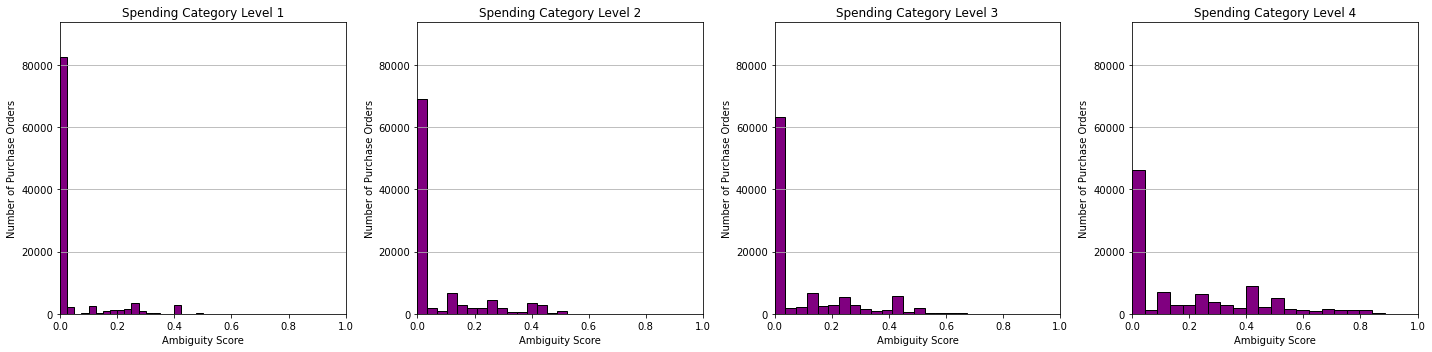

In [8]:
df = df_train.copy().sample(100000)


# Function to compute ambiguity scores for any category level
def get_ambiguity_scores(df, category_column):
    subset = df[[
        "puor_id_lfa1_supplier",
        "puor_id_t001_company",
        "puor_id_prgp_purchasing_group",
        "puor_id_pror_purchasing_org",
        category_column
    ]].copy()

    subset["group_key"] = subset[[
        "puor_id_lfa1_supplier", 
        "puor_id_t001_company", 
        "puor_id_prgp_purchasing_group", 
        "puor_id_pror_purchasing_org"
    ]].apply(lambda row: tuple(row), axis=1)

    dummies = pd.get_dummies(subset[category_column])
    counts_by_group = dummies.groupby(subset["group_key"]).sum()
    subset = subset.merge(counts_by_group, left_on="group_key", right_index=True, how="left")

    def compute_score(row):
        total = row[counts_by_group.columns].sum()
        max_count = row[counts_by_group.columns].max()
        return 1 - (max_count / total) if total > 0 else 0

    subset["ambiguity_score"] = subset.apply(compute_score, axis=1)
    return subset["ambiguity_score"]

# Get ambiguity scores for all levels
ambiguity_scores = {
    "Level 1": get_ambiguity_scores(df, "puor_ds_level1_new"),
    "Level 2": get_ambiguity_scores(df, "puor_ds_level2_new"),
    "Level 3": get_ambiguity_scores(df, "puor_ds_level3_new"),
    "Level 4": get_ambiguity_scores(df, "puor_ds_level4_new")
}

# Filter scores > 0.1 (i.e., the ambiguous ones)
# filtered_ambiguity_scores = {k: v[v >= 0] for k, v in ambiguity_scores.items()}

# Determine max y-axis value
all_filtered = pd.concat(ambiguity_scores.values())
hist_values, bin_edges = pd.cut(all_filtered, bins=20, retbins=True)
level1_scores = ambiguity_scores["Level 1"]
zero_scores_level1 = level1_scores[level1_scores == 0]
y_max = zero_scores_level1.value_counts().max()

# Create 2x2 subplot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.flatten()

for idx, (title, scores) in enumerate(ambiguity_scores.items()):
    axes[idx].hist(scores, bins=20, color="purple", edgecolor="black")
    axes[idx].set_title(f"Spending Category Level {idx+1}")
    axes[idx].set_xlabel("Ambiguity Score")
    axes[idx].set_ylabel("Number of Purchase Orders")
    axes[idx].set_ylim(0, y_max+20000)
    axes[idx].set_xlim(0, 1)    
    axes[idx].grid(axis="y")

plt.tight_layout()
plt.show()
